In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import xgboost as xgb
import HomeMade as hm
import pandas as pd

In [2]:
ML1 = "v0_chi2 v0_px1 v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 v0_px2 v0_px".split(" ")
# ML1 = "v0_chi2 v0_px1 v0_py1 v0_py v0_py2 v0_px2 v0_px".split(" ")
ML2 = "cosTheta a0xy a0 v0_y v0_x v0_rxyErr v0_rxy v0_z pv0_z pv0_y ntrk_pv0 pv0_x".split(" ")

In [3]:
N = 2e6

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2+["v0_ks_massErr"], entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
# train_split_data = len(data)//3
train_test_split_data = int(len(data)*0.5)
train_data = data[:train_test_split_data]
test_data = data[train_test_split_data:]

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2+['trueKs'], entrystop = N)

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]
train_test_split_mc = int(len(data)*0.8)
train_mc = mc[:train_test_split_mc]
test_mc = mc[train_test_split_mc:]

In [4]:
train_data.index

Int64Index([     0,      1,      3,      5,      7,      9,     10,     11,
                13,     15,
            ...
            996315, 996317, 996323, 996324, 996327, 996330, 996337, 996340,
            996344, 996346],
           dtype='int64', name='entry', length=408047)

In [5]:
# def reweight_train(data,mc,feats,cla,eval_data=None,eval_mc=None,plot=True,reweighing=True,q_weights=0.9999):
#     from sklearn.preprocessing import RobustScaler, MinMaxScaler
#     from hep_ml.reweight import GBReweighter
#     from sklearn.metrics import roc_curve, roc_auc_score

#     scaler_mc = MinMaxScaler()
#     scaler_data = MinMaxScaler()

#     def remove_outliers(data,q1=0.05,q2=0.95):
#         mask = np.ones(len(data),dtype=bool)
#         for col in data.columns:
#             mask *= data[col].between(data[col].quantile(q1),data[col].quantile(q2)).to_numpy()
#         return mask
    
#     #Try and remove outliers at first step
#     data = data[remove_outliers(data[feats])]
#     mc = mc[remove_outliers(mc[feats])]
    
#     data_split = len(data)//2
#     mc_split = len(mc)//2
    
#     train_data = data[:data_split]
#     train_data_cla = data[data_split:]
    
#     train_mc = mc[:mc_split]
#     train_mc_cla = mc[mc_split:]
    
# #     scaled_train_data = pd.DataFrame(scaler_data.fit_transform(train_data[feats][remove_outliers(train_data[feats])]),columns=feats)
# #     scaled_train_mc = pd.DataFrame(scaler_mc.fit_transform(train_mc[feats][remove_outliers(train_mc[feats])]),columns=feats)
#     scaled_train_data = pd.DataFrame(scaler_data.fit_transform(train_data[feats]),columns=feats)
#     scaled_train_mc = pd.DataFrame(scaler_mc.fit_transform(train_mc[feats]),columns=feats)

#     scaled_train_data_cla = pd.DataFrame(scaler_data.transform(train_data_cla[feats]),columns=feats)
#     scaled_train_mc_cla = pd.DataFrame(scaler_mc.transform(train_mc_cla[feats]),columns=feats)
    
# #     #Try and remove outliers
# #     scaled_train_data_cla[remove_outliers(scaled_train_data_cla)]
# #     scaled_train_mc_cla[remove_outliers(scaled_train_mc_cla)]
    
#     if plot:
#         for feat in feats:
#             scaled_train_data[feat].hist(bins=100,alpha=0.5);
#             scaled_train_mc[feat].hist(bins=100,alpha=0.5);
#             plt.yscale('log')
#             plt.title(feat)
#             plt.show()
    
#     if reweighing:
#         reweighter = GBReweighter(n_estimators=100,max_depth=4,min_samples_leaf=800,loss_regularization=10.0)
#         sample = min(len(scaled_train_mc),len(scaled_train_data))
#         reweighter.fit(original=scaled_train_mc.sample(sample), target=scaled_train_data.sample(sample))
        
#         mc_weights = reweighter.predict_weights(scaled_train_mc_cla)
        
#         mask = mc_weights < np.quantile(mc_weights, (q_weights))
        
#         plt.hist(mc_weights[mask],bins=100)
#         plt.yscale('log')
#         plt.xscale('log')
#         plt.show()
        
#         if plot:
#             print(len(scaled_train_data_cla),len(scaled_train_mc_cla[mask]))
#             for feat in feats:
#                 scaled_train_data_cla[feat].hist(bins=100,alpha=0.5);
#                 scaled_train_mc_cla[mask][feat].hist(bins=100,alpha=0.5,weights=mc_weights[mask]);
#                 plt.yscale('log')
#                 plt.title(feat)
#                 plt.show()
        
#         cla.fit(X=scaled_train_mc_cla[mask],
#                y=train_mc_cla.trueKs[mask],
#                sample_weight = mc_weights[mask])
        
#         if type(eval_data) != type(None) and type(eval_mc) != type(None):
#             scaled_eval_data = pd.DataFrame(scaler_data.transform(eval_data[feats]),columns=feats)
#             scaled_eval_mc = pd.DataFrame(scaler_mc.transform(eval_mc[feats]),columns=feats)
            
#             #Check how distinguishable after reweighing
#             eval_cla = xgb.XGBClassifier()
#             eval_cla.fit(X=pd.concat([scaled_train_mc_cla[mask],scaled_train_data_cla]),
#                         y=np.append(np.ones(len(scaled_train_mc_cla[mask])),np.zeros(len(scaled_train_data_cla))),
#                         sample_weight = np.append(mc_weights[mask],np.ones(len(scaled_train_data_cla))))
#             print(eval_cla.feature_importances_)
            
#             p_reweight = eval_cla.predict_proba(pd.concat([scaled_eval_data,scaled_eval_mc]))[:,1]
            
#             fig, ax = plt.subplots()
#             fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_eval_data)),np.ones(len(scaled_eval_mc))),p_reweight)
#             ax.plot(fpr,tpr,'b.')
            
#             #check before reweighing
#             eval_cla = xgb.XGBClassifier()
#             eval_cla.fit(X=pd.concat([scaled_train_mc_cla[mask],scaled_train_data_cla]),
#                         y=np.append(np.ones(len(scaled_train_mc_cla[mask])),np.zeros(len(scaled_train_data_cla))))
#             print(eval_cla.feature_importances_)
            
#             p_reweight = eval_cla.predict_proba(pd.concat([scaled_eval_data,scaled_eval_mc]))[:,1]
            
#             fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_eval_data)),np.ones(len(scaled_eval_mc))),p_reweight)
#             ax.plot(fpr,tpr,'rx')
#     else:
#         cla.fit(X=scaled_train_mc_cla,
#                 y=train_mc_cla.trueKs)
#     return scaler_data, scaler_mc
def reweight_train(data,mc,feats,cla,reweight_feats=None,eval_data=None,eval_mc=None,plot=True,reweighing=True,q_weights=0.9999):
    from sklearn.preprocessing import RobustScaler, MinMaxScaler
    from hep_ml.reweight import GBReweighter
    from sklearn.metrics import roc_curve, roc_auc_score

    scaler_mc = MinMaxScaler()
    scaler_data = MinMaxScaler()

    def remove_outliers(data,q1=0.05,q2=0.95):
        mask = np.ones(len(data),dtype=bool)
        for col in data.columns:
            mask *= data[col].between(data[col].quantile(q1),data[col].quantile(q2)).to_numpy()
        return mask
    
    #Try and remove outliers at first step
    data = data[remove_outliers(data[feats])]
    mc = mc[remove_outliers(mc[feats])]
    
    data_split = len(data)//2
    mc_split = len(mc)//2
    
    train_data = data[:data_split]
    train_data_cla = data[data_split:]
    
    train_mc = mc[:mc_split]
    train_mc_cla = mc[mc_split:]
    
#     scaled_train_data = pd.DataFrame(scaler_data.fit_transform(train_data[feats][remove_outliers(train_data[feats])]),columns=feats)
#     scaled_train_mc = pd.DataFrame(scaler_mc.fit_transform(train_mc[feats][remove_outliers(train_mc[feats])]),columns=feats)
    scaled_train_data = pd.DataFrame(scaler_data.fit_transform(train_data[feats]),columns=feats)
    scaled_train_mc = pd.DataFrame(scaler_mc.fit_transform(train_mc[feats]),columns=feats)

    scaled_train_data_cla = pd.DataFrame(scaler_data.transform(train_data_cla[feats]),columns=feats)
    scaled_train_mc_cla = pd.DataFrame(scaler_mc.transform(train_mc_cla[feats]),columns=feats)
    
#     #Try and remove outliers
#     scaled_train_data_cla[remove_outliers(scaled_train_data_cla)]
#     scaled_train_mc_cla[remove_outliers(scaled_train_mc_cla)]
    
    if plot:
        for feat in feats:
            scaled_train_data[feat].hist(bins=100,alpha=0.5);
            scaled_train_mc[feat].hist(bins=100,alpha=0.5);
            plt.yscale('log')
            plt.title(feat)
            plt.show()
    
    if reweighing:
        if not reweight_feats:
            reweight_feats = feats
        reweighter = GBReweighter(n_estimators=100,max_depth=2,min_samples_leaf=800,loss_regularization=10.0)
        sample = min(len(scaled_train_mc),len(scaled_train_data))
        reweighter.fit(original=scaled_train_mc[reweight_feats].sample(sample), target=scaled_train_data[reweight_feats].sample(sample))
        
        mc_weights = reweighter.predict_weights(scaled_train_mc_cla[reweight_feats])
        
        mask = mc_weights < np.quantile(mc_weights, (q_weights))
        
        plt.hist(mc_weights[mask],bins=100)
        plt.yscale('log')
        plt.xscale('log')
        plt.show()
        
        if plot:
            print(len(scaled_train_data_cla),len(scaled_train_mc_cla[mask]))
            for feat in feats:
                scaled_train_data_cla[feat].hist(bins=100,alpha=0.5);
                scaled_train_mc_cla[mask][feat].hist(bins=100,alpha=0.5,weights=mc_weights[mask]);
                plt.yscale('log')
                plt.title(feat)
                plt.show()
        
        cla.fit(X=scaled_train_mc_cla[mask],
               y=train_mc_cla.trueKs[mask],
               sample_weight = mc_weights[mask])
        
        if type(eval_data) != type(None) and type(eval_mc) != type(None):
            scaled_eval_data = pd.DataFrame(scaler_data.transform(eval_data[feats]),columns=feats)
            scaled_eval_mc = pd.DataFrame(scaler_mc.transform(eval_mc[feats]),columns=feats)
            
            #Check how distinguishable after reweighing
            eval_cla = xgb.XGBClassifier()
            eval_cla.fit(X=pd.concat([scaled_train_mc_cla[mask],scaled_train_data_cla]),
                        y=np.append(np.ones(len(scaled_train_mc_cla[mask])),np.zeros(len(scaled_train_data_cla))),
                        sample_weight = np.append(mc_weights[mask],np.ones(len(scaled_train_data_cla))))
            print(eval_cla.feature_importances_)
            
            p_reweight = eval_cla.predict_proba(pd.concat([scaled_eval_data,scaled_eval_mc]))[:,1]
            
            fig, ax = plt.subplots()
            fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_eval_data)),np.ones(len(scaled_eval_mc))),p_reweight)
            ax.plot(fpr,tpr,'b.')
            
            #check before reweighing
            eval_cla = xgb.XGBClassifier()
            eval_cla.fit(X=pd.concat([scaled_train_mc_cla[mask],scaled_train_data_cla]),
                        y=np.append(np.ones(len(scaled_train_mc_cla[mask])),np.zeros(len(scaled_train_data_cla))))
            print(eval_cla.feature_importances_)
            
            p_reweight = eval_cla.predict_proba(pd.concat([scaled_eval_data,scaled_eval_mc]))[:,1]
            
            fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_eval_data)),np.ones(len(scaled_eval_mc))),p_reweight)
            ax.plot(fpr,tpr,'rx')
    else:
        cla.fit(X=scaled_train_mc_cla,
                y=train_mc_cla.trueks)
    if reweighing:
        return scaler_data, scaler_mc, reweighter
    return scaler_data, scaler_mc

Reweighting is hard, some of the following is just to produce figures of models trained in scaled MC and evaluated in data:

In [6]:
cla1 = xgb.XGBClassifier()
cla2 = xgb.XGBClassifier()

In [6]:
scaler_data_1, scaler_mc_1 = reweight_train(train_data,train_mc,ML1,cla1,reweighing=False,plot=False)

C:\Users\jv97\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\jv97\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


C:\Users\jv97\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Completed fit with Chi2: 99.6, p-val: 0.253 and the total amount of signal 19650 +/- 376, background: 388398
Completed fit with Chi2: 102.3, p-val: 0.196 and the total amount of signal 15984 +/- 213, background: 383904
Completed fit with Chi2: 105.6, p-val: 0.140 and the total amount of signal 12875 +/- 323, background: 378852
No valid minimum found!
Completed fit with Chi2: 103.1, p-val: 0.183 and the total amount of signal 10344 +/- 14074, background: 373222
Completed fit with Chi2: 110.2, p-val: 0.084 and the total amount of signal 8373 +/- 293, background: 367033
Completed fit with Chi2: 114.3, p-val: 0.050 and the total amount of signal 6841 +/- 318, background: 360403
Completed fit with Chi2: 112.7, p-val: 0.062 and the total amount of signal 5593 +/- 122, background: 353490
No valid minimum found!
Completed fit with Chi2: 118.0, p-val: 0.030 and the total amount of signal 4664 +/- 12146, background: 346259


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


Completed fit with Chi2: 122.3, p-val: 0.016 and the total amount of signal 3855 +/- 97, background: 338907
Completed fit with Chi2: 123.9, p-val: 0.013 and the total amount of signal 3369 +/- 165, background: 331232
Completed fit with Chi2: 126.4, p-val: 0.008 and the total amount of signal 2947 +/- 244, background: 323492
Completed fit with Chi2: 132.1, p-val: 0.003 and the total amount of signal 2550 +/- 166, background: 315728
No valid minimum found!
Completed fit with Chi2: 135.9, p-val: 0.002 and the total amount of signal 2312 +/- 10760, background: 307805
Completed fit with Chi2: 134.9, p-val: 0.002 and the total amount of signal 2040 +/- 175, background: 299916
Completed fit with Chi2: 130.0, p-val: 0.005 and the total amount of signal 1861 +/- 187, background: 291935
Completed fit with Chi2: 128.5, p-val: 0.006 and the total amount of signal 1676 +/- 283, background: 283958
Completed fit with Chi2: 128.9, p-val: 0.005 and the total amount of signal 1581 +/- 16, background: 27

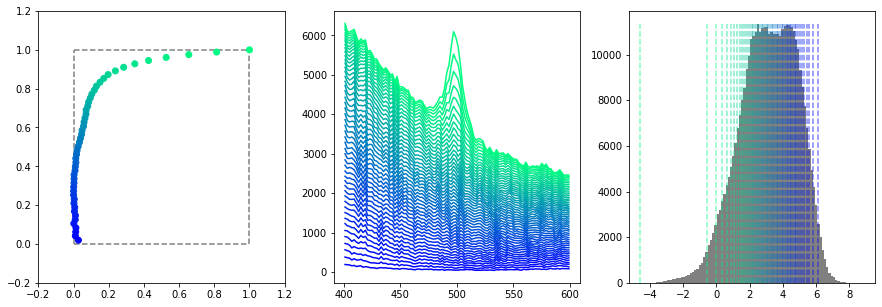

In [8]:
import importlib
hm = importlib.reload(hm)

p1 = cla1.predict_proba(pd.DataFrame(scaler_mc_1.transform(test_data[ML1]),columns=ML1))[:,0]

fig1, ax1 = plt.subplots(figsize = (15,5),ncols=3)

AUC1, cuts1 = hm.roc_curve_data(test_data.v0_ks_mass, p1,Npoints=50,ax_roc=ax1[0],ax_fits=ax1[1],ax_hist=ax1[2])

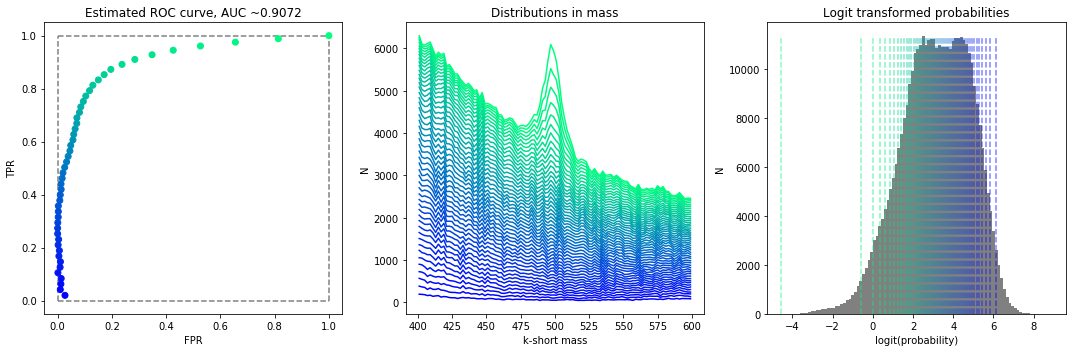

In [18]:
ax1[0].set(title=f'Estimated ROC curve, AUC ~{(1+AUC1):.4f}',xlabel='FPR',ylabel='TPR',xlim=(-0.05,1.05),ylim=(-0.05,1.05))
ax1[1].set(title='Distributions in mass',xlabel='k-short mass',ylabel='N')
ax1[2].set(title='Logit transformed probabilities',xlabel='logit(probability)',ylabel='N')
fig1.tight_layout()
# fig1.savefig('figures/ML1_roc_scaled_MC.pdf')
fig1

In [14]:
scaler_data_2, scaler_mc_2 = reweight_train(train_data,train_mc,ML2,cla2,reweighing=False,plot=False)

C:\Users\jv97\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Completed fit with Chi2: 99.6, p-val: 0.253 and the total amount of signal 19650 +/- 376, background: 388398
Completed fit with Chi2: 102.9, p-val: 0.185 and the total amount of signal 12675 +/- 184, background: 387214
Completed fit with Chi2: 105.4, p-val: 0.144 and the total amount of signal 6839 +/- 299, background: 384888
No valid minimum found!
Completed fit with Chi2: 113.5, p-val: 0.055 and the total amount of signal 2573 +/- 744, background: 380994
Completed fit with Chi2: 113.6, p-val: 0.054 and the total amount of signal 1059 +/- 76, background: 374347
Completed fit with Chi2: 119.5, p-val: 0.024 and the total amount of signal 609 +/- 178, background: 366635
Completed fit with Chi2: 125.6, p-val: 0.009 and the total amount of signal 231 +/- 197, background: 358852
Completed fit with Chi2: 123.3, p-val: 0.014 and the total amount of signal 308 +/- 9, background: 350615
Completed fit with Chi2: 126.9, p-val: 0.008 and the total amount of signal 284 +/- 183, background: 342478
C

C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


Completed fit with Chi2: 121.9, p-val: 0.017 and the total amount of signal 123 +/- 163, background: 138615
Completed fit with Chi2: 121.3, p-val: 0.019 and the total amount of signal 211 +/- 118, background: 130366
Completed fit with Chi2: 110.9, p-val: 0.076 and the total amount of signal 146 +/- 156, background: 122269
Completed fit with Chi2: 120.8, p-val: 0.020 and the total amount of signal 197 +/- 83, background: 114057
Completed fit with Chi2: 117.8, p-val: 0.031 and the total amount of signal 193 +/- 149, background: 105901
Completed fit with Chi2: 123.7, p-val: 0.013 and the total amount of signal 255 +/- 150, background: 97677
Completed fit with Chi2: 125.2, p-val: 0.010 and the total amount of signal 244 +/- 139, background: 89527
Completed fit with Chi2: 114.4, p-val: 0.049 and the total amount of signal 257 +/- 128, background: 81354
Completed fit with Chi2: 102.1, p-val: 0.201 and the total amount of signal 275 +/- 136, background: 73174
Completed fit with Chi2: 97.1, p-

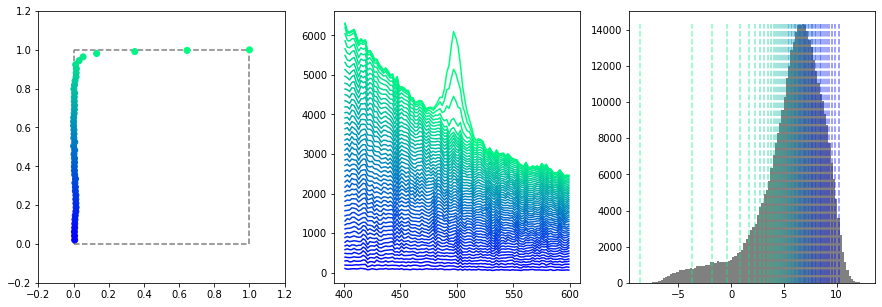

In [15]:
p2 = cla2.predict_proba(pd.DataFrame(scaler_mc_2.transform(test_data[ML2]),columns=ML2))[:,0]

fig2, ax2 = plt.subplots(figsize = (15,5),ncols=3)

AUC2, cuts2 = hm.roc_curve_data(test_data.v0_ks_mass, p2,Npoints=50,ax_roc=ax2[0],ax_fits=ax2[1],ax_hist=ax2[2])

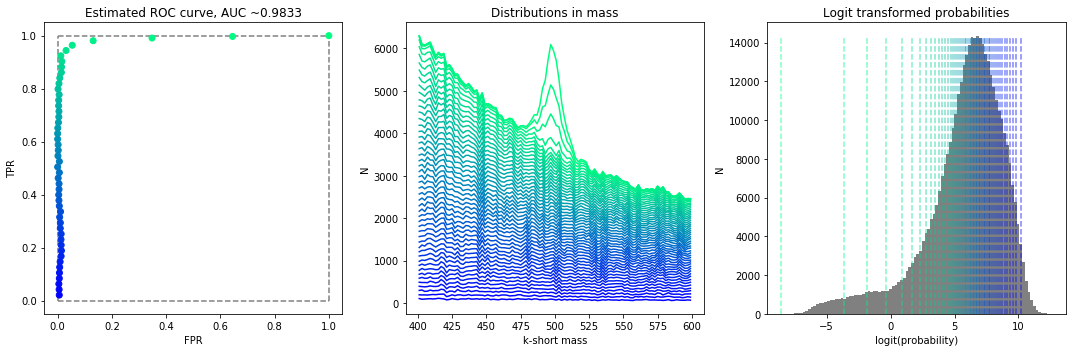

In [17]:
ax2[0].set(title=f'Estimated ROC curve, AUC ~{(1+AUC2):.4f}',xlabel='FPR',ylabel='TPR',xlim=(-0.05,1.05),ylim=(-0.05,1.05))
ax2[1].set(title='Distributions in mass',xlabel='k-short mass',ylabel='N')
ax2[2].set(title='Logit transformed probabilities',xlabel='logit(probability)',ylabel='N')
fig2.tight_layout()
# fig2.savefig('figures/ML2_roc_scaled_MC.pdf')
fig2

In [7]:
cla_reweight = xgb.XGBClassifier()
cla_reweight1 = xgb.XGBClassifier()
cla_reweight2 = xgb.XGBClassifier()
# cla1 = xgb.XGBClassifier()
# cla2 = xgb.XGBClassifier()

In [8]:
# ML1 = "v0_chi2 v0_px1 v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 v0_px2 v0_px".split(" ")
# ML2 = "cosTheta a0xy a0 v0_y v0_x v0_rxyErr v0_rxy v0_z pv0_z pv0_y ntrk_pv0 pv0_x".split(" ")
reweight_feats = "v0_chi2 v0_px1 v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 v0_px2 v0_px a0xy a0 v0_y v0_x v0_rxyErr v0_rxy v0_z".split(" ")

C:\Users\jv97\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\jv97\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


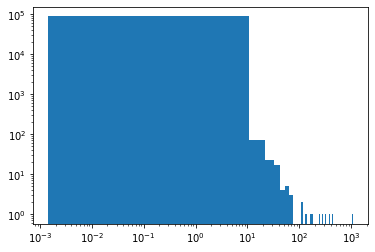

In [9]:
# scaler_data_reweight, scaler_mc_reweight, reweighter = reweight_train(train_data,train_mc,ML1+ML2,cla_reweight,reweight_feats,test_data,test_mc,q_weights=1)
scaler_data_reweight, scaler_mc_reweight, reweighter = reweight_train(train_data,train_mc,ML1+ML2,cla_reweight,reweight_feats,q_weights=1,plot=False)

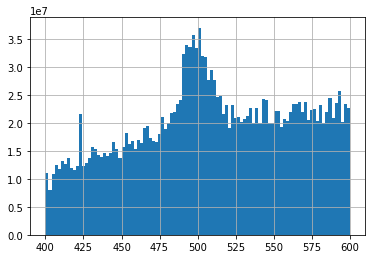

In [39]:
test_mc.v0_ks_mass.hist(bins=100,weights=reweighter.predict_weights(test_mc[reweight_feats]));

In [13]:
p = cla_reweight.predict_proba(pd.DataFrame(scaler_mc_reweight.transform(test_data[ML1+ML2]),columns=ML1+ML2))[:,0]

No background valid minimum found!
No valid minimum found!


(400, 650)

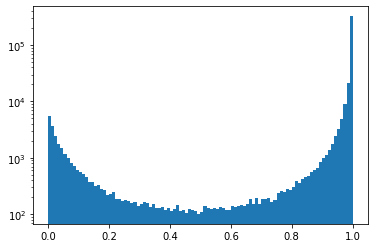

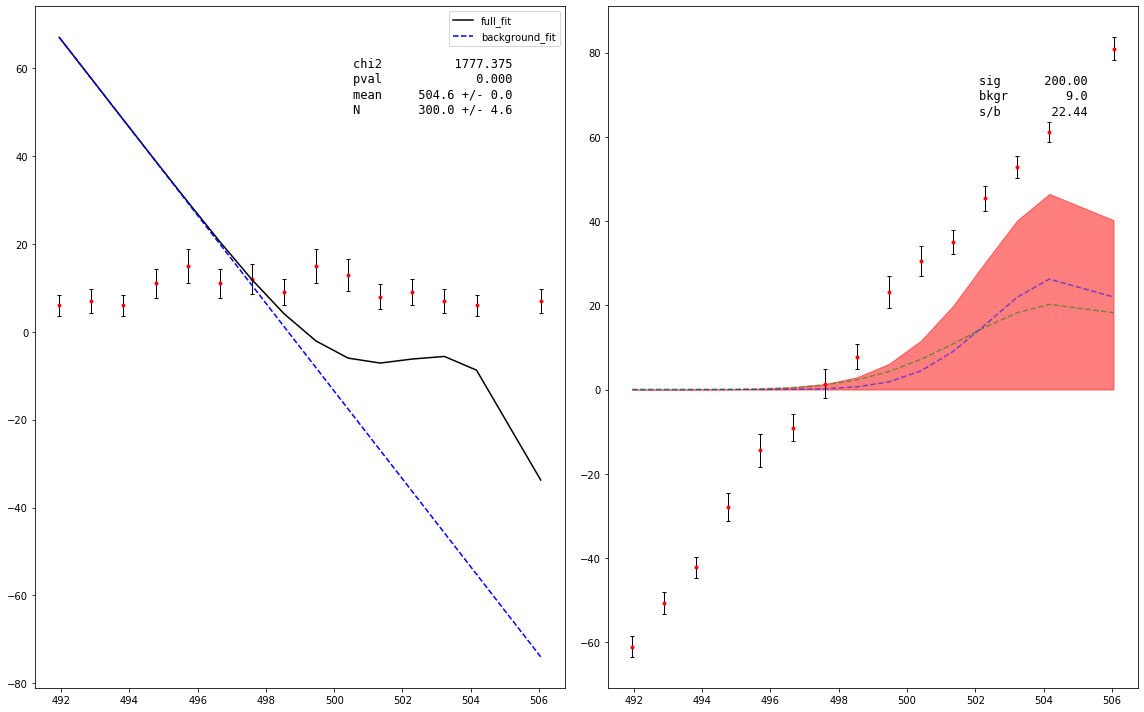

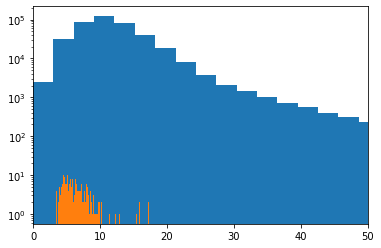

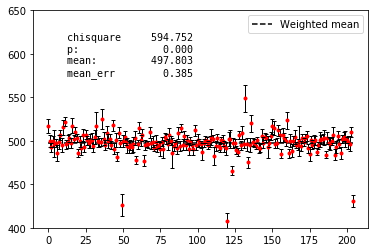

In [22]:
import importlib
from scipy.special import logit
# plt.hist(logit(p),bins=100);
plt.hist(p,bins=100);
plt.yscale('log')

hm = importlib.reload(hm)
mask_mass = p<= np.quantile(p,0.0005)
vals, binc, binw = hm.hist(test_data.v0_ks_mass[mask_mass],bins=150)

# fig, ax = plt.subplots()
# ax.hist(test_data.v0_ks_mass[p<=0.38],bins=100);
mask = vals >5
D = hm.fit_mass2(binc[mask],vals[mask],np.sqrt(vals[mask]))

plt.figure()
plt.hist(test_data.v0_ks_massErr,bins=100);
plt.hist(test_data.v0_ks_massErr[mask_mass],bins=100);
plt.yscale('log')
plt.xlim(0,50)

hm = importlib.reload(hm)
fig, ax = plt.subplots()
hm.weighted_mean(test_data.v0_ks_mass[mask_mass],test_data.v0_ks_massErr[mask_mass],ax=ax)
ax.set_ylim(400,650)

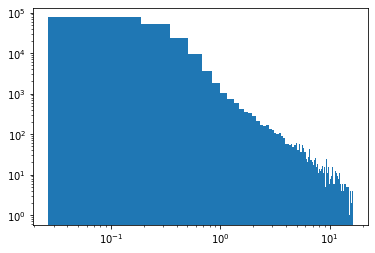

In [13]:
# scaler_data_reweight1, scaler_mc_reweight1 = reweight_train(train_data,train_mc,ML1,cla_reweight1,test_data,test_mc,q_weights=0.999)
scaler_data_reweight1, scaler_mc_reweight1, reweighter1 = reweight_train(train_data,train_mc,ML1,cla_reweight1,q_weights=0.999,plot=False)

In [58]:
scaler_data_1, scaler_mc_1 = reweight_train(train_data,train_mc,ML1,cla1,reweighing=False,plot=False)

C:\Users\jv97\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Completed fit with Chi2: 99.6, p-val: 0.253 and the total amount of signal 19650 +/- 376, background: 388398
Completed fit with Chi2: 101.3, p-val: 0.216 and the total amount of signal 15379 +/- 187, background: 384510
Completed fit with Chi2: 100.4, p-val: 0.234 and the total amount of signal 11775 +/- 219, background: 379953
Completed fit with Chi2: 101.7, p-val: 0.208 and the total amount of signal 9234 +/- 235, background: 374333
Completed fit with Chi2: 102.4, p-val: 0.195 and the total amount of signal 7572 +/- 327, background: 367833
Completed fit with Chi2: 106.7, p-val: 0.125 and the total amount of signal 6478 +/- 327, background: 360766
Completed fit with Chi2: 113.1, p-val: 0.058 and the total amount of signal 5547 +/- 200, background: 353537
Completed fit with Chi2: 118.3, p-val: 0.029 and the total amount of signal 4932 +/- 217, background: 345991
Completed fit with Chi2: 119.8, p-val: 0.023 and the total amount of signal 4372 +/- 170, background: 338390
Completed fit wit

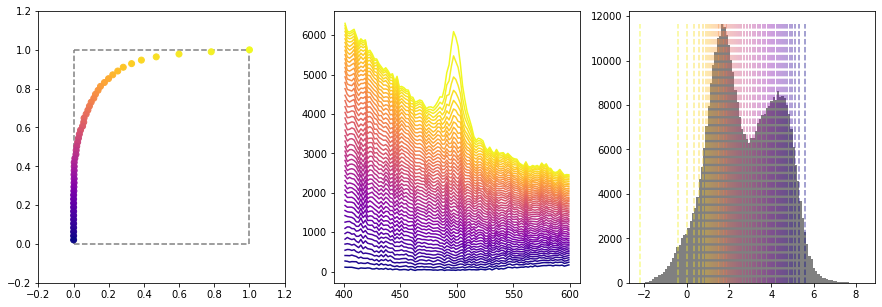

In [38]:
import importlib 
hm = importlib.reload(hm)

p1_reweight = cla_reweight1.predict_proba(pd.DataFrame(scaler_mc_reweight1.transform(test_data[ML1]),columns=ML1))[:,0]

fig1r, ax1r = plt.subplots(figsize = (15,5),ncols=3)

AUC1r, cuts1r = hm.roc_curve_data(test_data.v0_ks_mass, p1_reweight,Npoints=50,ax_roc=ax1r[0],ax_fits=ax1r[1],ax_hist=ax1r[2])

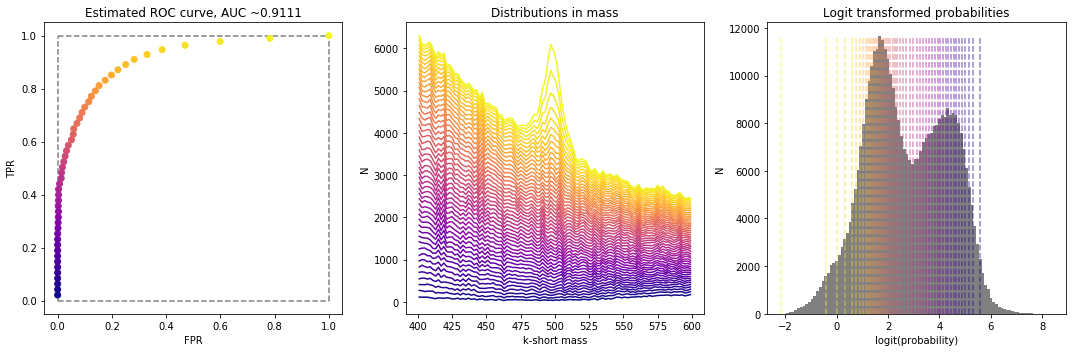

In [41]:
ax1r[0].set(title=f'Estimated ROC curve, AUC ~{(1+AUC1r):.4f}',xlabel='FPR',ylabel='TPR',xlim=(-0.05,1.05),ylim=(-0.05,1.05))
ax1r[1].set(title='Distributions in mass',xlabel='k-short mass',ylabel='N')
ax1r[2].set(title='Logit transformed probabilities',xlabel='logit(probability)',ylabel='N')
fig1r.tight_layout()
# fig1r.savefig('figures/ML1_roc_reweighted_MC.pdf')
fig1r

In [11]:
ML2

['cosTheta',
 'a0xy',
 'a0',
 'v0_y',
 'v0_x',
 'v0_rxyErr',
 'v0_rxy',
 'v0_z',
 'pv0_z',
 'pv0_y',
 'ntrk_pv0',
 'pv0_x']

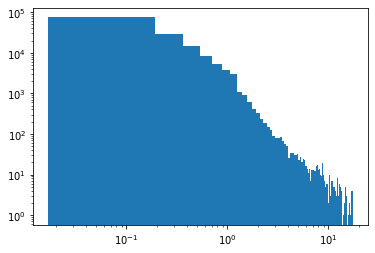

In [14]:
# scaler_data_reweight2, scaler_mc_reweight2 = reweight_train(train_data,train_mc,ML2,cla_reweight2,test_data,test_mc,q_weights=0.999)
reweight_feats = "a0xy a0 v0_y v0_x v0_rxyErr v0_rxy v0_z".split(" ")
scaler_data_reweight2, scaler_mc_reweight2, reweighter2 = reweight_train(train_data,train_mc,ML2,cla_reweight2,reweight_feats,q_weights=0.999,plot=False)

C:\Users\jv97\anaconda3\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Completed fit with Chi2: 99.6, p-val: 0.253 and the total amount of signal 19650 +/- 376, background: 388398
No valid minimum found!
Completed fit with Chi2: 99.9, p-val: 0.246 and the total amount of signal 13275 +/- 14489, background: 386614
Completed fit with Chi2: 107.1, p-val: 0.119 and the total amount of signal 6666 +/- 226, background: 385062
Completed fit with Chi2: 109.2, p-val: 0.094 and the total amount of signal 2697 +/- 197, background: 380870
Completed fit with Chi2: 107.3, p-val: 0.117 and the total amount of signal 757 +/- 209, background: 374649
Completed fit with Chi2: 108.9, p-val: 0.097 and the total amount of signal 582 +/- 261, background: 366663
Completed fit with Chi2: 108.9, p-val: 0.097 and the total amount of signal 312 +/- 103, background: 358771


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


Completed fit with Chi2: 105.0, p-val: 0.150 and the total amount of signal 263 +/- nan, background: 350660
Completed fit with Chi2: 108.7, p-val: 0.099 and the total amount of signal 304 +/- 205, background: 342457
Completed fit with Chi2: 115.5, p-val: 0.042 and the total amount of signal 252 +/- 180, background: 334348
Completed fit with Chi2: 114.1, p-val: 0.051 and the total amount of signal 198 +/- 124, background: 326242
Completed fit with Chi2: 114.0, p-val: 0.052 and the total amount of signal 165 +/- 173, background: 318113
Completed fit with Chi2: 114.2, p-val: 0.051 and the total amount of signal 180 +/- 11405, background: 309938


C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


Completed fit with Chi2: 114.4, p-val: 0.049 and the total amount of signal 115 +/- nan, background: 301841
Completed fit with Chi2: 112.9, p-val: 0.060 and the total amount of signal 55 +/- 193, background: 293740
Completed fit with Chi2: 114.9, p-val: 0.046 and the total amount of signal 40 +/- 266, background: 285595
Completed fit with Chi2: 112.4, p-val: 0.063 and the total amount of signal 24 +/- nan, background: 277450
No valid minimum found!
Completed fit with Chi2: 110.3, p-val: 0.083 and the total amount of signal 2 +/- 11995, background: 269310
Completed fit with Chi2: 111.9, p-val: 0.067 and the total amount of signal 0 +/- 18501, background: 261151
No valid minimum found!
Completed fit with Chi2: 105.4, p-val: 0.144 and the total amount of signal 10 +/- 12366, background: 252980
Completed fit with Chi2: 102.9, p-val: 0.185 and the total amount of signal 0 +/- 12964, background: 244829
Completed fit with Chi2: 104.8, p-val: 0.154 and the total amount of signal 114 +/- 234, b

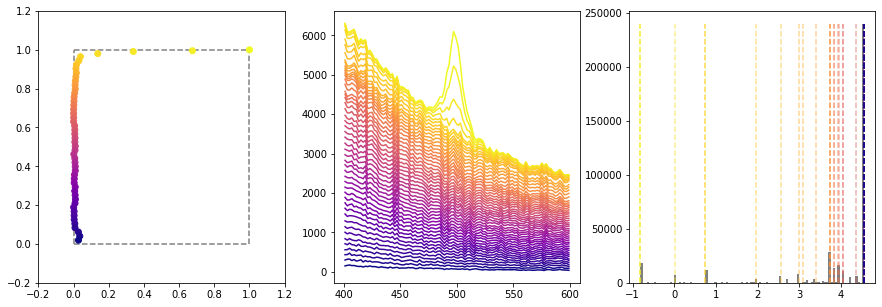

In [35]:
import importlib 
hm = importlib.reload(hm)

p2_reweight = cla_reweight2.predict_proba(pd.DataFrame(scaler_mc_reweight2.transform(test_data[ML2]),columns=ML2))[:,0]

fig2r, ax2r = plt.subplots(figsize = (15,5),ncols=3)

AUC2r, cuts2r = hm.roc_curve_data(test_data.v0_ks_mass, p2_reweight,Npoints=50,ax_roc=ax2r[0],ax_fits=ax2r[1],ax_hist=ax2r[2])

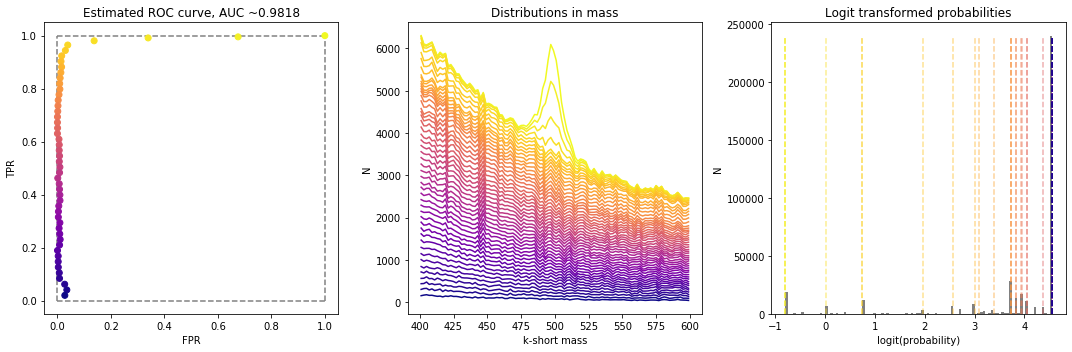

In [42]:
ax2r[0].set(title=f'Estimated ROC curve, AUC ~{(1+AUC2r):.4f}',xlabel='FPR',ylabel='TPR',xlim=(-0.05,1.05),ylim=(-0.05,1.05))
ax2r[1].set(title='Distributions in mass',xlabel='k-short mass',ylabel='N')
ax2r[2].set(title='Logit transformed probabilities',xlabel='logit(probability)',ylabel='N')
fig2r.tight_layout()
# fig2r.savefig('figures/ML2_roc_reweighted_MC.pdf')
fig2r

In [15]:
N = None

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2+["v0_ks_massErr"], entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
# train_split_data = len(data)//3
train_test_split_data = int(len(data)*0.8)
train_data = data[:train_test_split_data]
test_data = data[train_test_split_data:]

In [17]:
p = cla_reweight.predict_proba(pd.DataFrame(scaler_mc_reweight.transform(test_data[ML1+ML2]),columns=ML1+ML2))[:,0]
p1 = cla_reweight1.predict_proba(pd.DataFrame(scaler_mc_reweight1.transform(test_data[ML1]),columns=ML1))[:,0]
p2 = cla_reweight2.predict_proba(pd.DataFrame(scaler_mc_reweight2.transform(test_data[ML2]),columns=ML2))[:,0]

In [18]:
df = pd.read_pickle('ks_predictions.dat')

In [22]:
cf = pd.concat([df,
          pd.Series(p1,name='ML1_MC',index=test_data.index),
          pd.Series(p2,name='ML2_MC',index=test_data.index),
          pd.Series(p,name='ML12_MC',index=test_data.index)],axis=1)

In [25]:
cf.head()

,v0_ks_mass,v0_ks_massErr,ML1_data,ML2_data,ML12_data,ML1_MC,ML2_MC,ML12_MC
entry,,,,,,,,
4704896,521.186951,15.050436,0.789591,0.755486,0.786765,0.994010,0.999004,0.999766
4704899,432.290253,8.782795,0.792817,0.783190,0.820879,0.995022,0.962926,0.995481
4704900,452.477722,8.867375,0.756234,0.764244,0.822262,0.974884,0.984198,0.988335
4704901,470.771179,8.400566,0.773028,0.808131,0.792001,0.873620,0.984124,0.985919
4704902,517.689758,8.674057,0.739633,0.721201,0.702930,0.937822,0.996806,0.999143


In [26]:
# cf.to_pickle('ks_predictions.dat')